# Object detection implementations 

In [5]:
!ls 

clear_path_extraction_notebook.ipynb
full_model.ipynb
object_detection-segmentation-depth-path.ipynb
output_object_detection.mp4


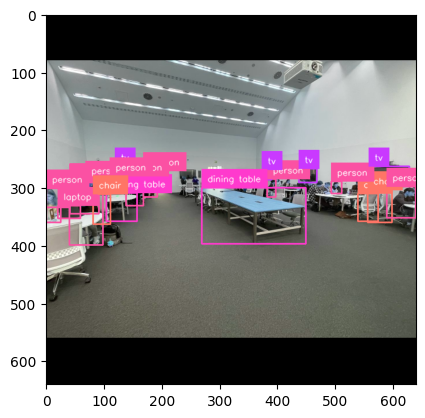

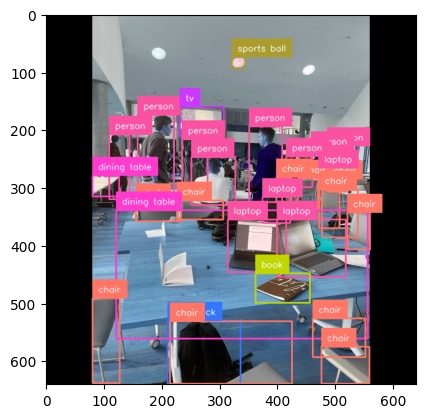

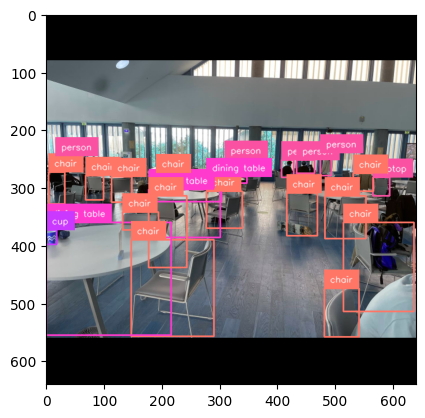

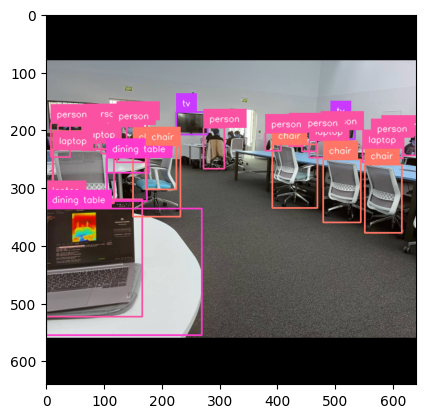

Annotated image is saved to: ../images/annotated
2.9659583568573


In [7]:
import cv2 
from ultralytics import YOLO 
import os 
import supervision as sv
import numpy as np 
import matplotlib.pyplot as plt 
model_path = r"../model/yolov8n.pt"
video_input = r"../videos/video0.mp4"
video_output = r"../videos/output_object-detection.mp4"
images_path = r"../images"
image0_path =  r"../images/image1.jpg"

def resize_and_pad(image, target_size=(640,640)):
    h,w = image.shape[:2]
    scale = min(target_size[0]/w, target_size[1]/h)
    new_w, new_h = int(w*scale), int(h*scale)
    resized = cv2.resize(image,(new_w, new_h), interpolation=cv2.INTER_AREA)

    # Padding the image 
    pad_w, pad_h = target_size[0]-new_w, target_size[1]-new_h
    top = pad_h//2
    bottom = pad_h - top
    left = pad_w//2
    right = pad_w - left
    padded = cv2.copyMakeBorder(resized,top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])
    return padded

# Draw helper 
def object_detection_images(model_path=model_path, images_path=images_path):
    model=YOLO(model_path)
    model_name = model.names 
    out_dir = os.path.join(images_path,"annotated")
    os.makedirs(out_dir,exist_ok=True)
    # Supervision annotators 
    # palette = sv.ColorPalette.default()
    box_annotator = sv.BoxAnnotator(thickness=2)
    label_annotator = sv.LabelAnnotator(text_scale=0.5,text_thickness=1)
    # trace_annotator = sv.TraceAnnotator(thickness=2,trace_length=40, position=sv.Position.BOTTOM_CENTER)
    # heatmap_annotator = sv.HeatMapAnnotator(opacity=0.35)
    for fname in os.listdir(images_path):
        if not fname.lower().endswith((".jpg","jpeg",".png")):
            continue 
        p = os.path.join(images_path, fname)
        img = cv2.imread(p)
        image = resize_and_pad(img)
        results = model(image, conf=0.25, iou=0.45,verbose=False)[0]
        detections = sv.Detections.from_ultralytics(results)
        if len(detections)==0:
            cv2.imwrite(os.path.join(out_dir,fname),image)
            continue 
        # labels = [f"{model_name.get(int(c),str(int(c)))} {conf:.2f}" for c,conf in zip(detections.class_id,detections.confidence)]
        image = box_annotator.annotate(scene=image, detections = detections)
        # image = label_annotator.annotate(scene=image,detections=detections,labels=labels)
        image = label_annotator.annotate(scene=image,detections=detections)
        cv2.imwrite(os.path.join(out_dir,fname), image)
        plt.imshow(image)
        plt.show()
    print(f"Annotated image is saved to: {out_dir}")



import time 
t0=time.time()
object_detection_images()
t1 = time.time()
print(t1-t0)

In [9]:
!pip install timm 


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [12]:
from ultralytics import YOLO
import supervision as sv
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = YOLO("../model/yolov8n.pt").to(device)
import imageio
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image
def object_detection_image(model, image):
    # Supervision annotators  
    box_annotator = sv.BoxAnnotator(thickness=1)
    label_annotator = sv.LabelAnnotator(text_scale=0.5,text_thickness=1)
        
    results = model(image, conf=0.25, iou=0.45,verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    if len(detections)==0:
        return image.copy()
    annotated_image = image.copy()
    image = box_annotator.annotate(scene=annotated_image, detections = detections)
    image = label_annotator.annotate(scene=annotated_image,detections=detections)
    return image
def segmentation_image(model,image):
    mask_annotator = sv.MaskAnnotator(opacity=0.5)
    label_annotator = sv.LabelAnnotator(text_scale=0.5,text_thickness=1)
        
    results = model(image,task="segment", conf=0.25, iou=0.45,verbose=False,device="cpu")[0]
    detections = sv.Detections.from_ultralytics(results)
    if len(detections)==0:
        return image.copy()
    annotated_image = image.copy()
    image = mask_annotator.annotate(scene=annotated_image, detections = detections)
    image = label_annotator.annotate(scene=annotated_image,detections=detections)
    return image
def resize_and_pad(image, target_size=(640,640)):
    h,w = image.shape[:2]
    scale = min(target_size[0]/w, target_size[1]/h)
    new_w, new_h = int(w*scale), int(h*scale)
    resized = cv2.resize(image,(new_w, new_h), interpolation=cv2.INTER_AREA)

    # Padding the image 
    # pad_w, pad_h = target_size[0]-new_w, target_size[1]-new_h
    # top = pad_h//2
    # bottom = pad_h - top
    # left = pad_w//2
    # right = pad_w - left
    # padded = cv2.copyMakeBorder(resized,top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0,0,0])
    # return padded
    return resized

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch.nn.functional as F


def depth_estimation_image(model, transform, image_bgr, device):
    # image_bgr: np.ndarray in BGR (cv2)
    img_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Transform → ensure batch dim
    inp = transform(img_rgb).to(device)
    if inp.ndim == 3:  # (C, H, W)
        inp = inp.unsqueeze(0)  # (1, C, H, W)

    with torch.no_grad():
        pred = model(inp)
        # Ensure shape is (N=1, C=1, H, W) for interpolate
        if pred.ndim == 4 and pred.shape[1] == 1:
            pass
        elif pred.ndim == 4 and pred.shape[1] != 1:
            pred = pred[:, :1, ...]  # take first channel
        elif pred.ndim == 3:
            pred = pred.unsqueeze(1)
        elif pred.ndim == 2:
            pred = pred.unsqueeze(0).unsqueeze(0)
        else:
            raise ValueError(f"Unexpected MiDaS output shape: {tuple(pred.shape)}")

        # Resize to original image size → (H, W)
        h, w = img_rgb.shape[:2]
        pred = F.interpolate(pred, size=(h, w), mode="bicubic", align_corners=False)
        depth = pred.squeeze(0).squeeze(0).cpu().numpy()

    # Normalize for visualization
    depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)
    depth_u8 = (depth_norm * 255).astype(np.uint8)
    depth_color = cv2.applyColorMap(depth_u8, cv2.COLORMAP_INFERNO)
    depth_color = cv2.cvtColor(depth_color, cv2.COLOR_BGR2RGB)
    return depth_color, depth_norm
def clear_pixel_path(image_bgr, model_obj_seg, model_depth, midas_transform, device,
                     group_width=64, focus_band=(0.7, 1.0),
                     occ_max=0.02, near_threshold=0.6, near_max=0.2,
                     return_scores=False):
    """
    image_bgr: np.ndarray (BGR)
    model_obj_seg: ultralytics.YOLO (seg model)
    model_depth: MiDaS model
    midas_transform: MiDaS transform
    device: torch.device
    group_width: 64 → 10 groups across 640 width
    focus_band: (start_h_frac, end_h_frac), part of image height to evaluate (e.g., road band)
    occ_max: max fraction of pixels occupied by objects in the region
    near_threshold: depth_norm > threshold considered 'near'
    near_max: max fraction of 'near' pixels allowed
    return_scores: if True returns per-group metrics

    Returns:
      - clear_groups: list of group indices that are clear
      - ranges: list of (x0, x1) pixel ranges in 640-scale image
      - (optional) scores: list of dict per group with occ_ratio, near_ratio
    """
    # Ensure 640x640 input
    # img_640 = cv2.resize(image_bgr, (640, 640), interpolation=cv2.INTER_AREA)
    # img_640 = cv2.cvtColor(image_bgr,cv2.COLOR_BGR2RGB)
    img_640 = image_bgr
    h, w = img_640.shape[:2]
    # assert w == 640 and h == 640, "Expected 640x640 after resize"

    # Segmentation → combined object mask
    results = model_obj_seg(img_640, task="segment", conf=0.25, iou=0.45, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    if len(detections)==0:
        return img_640.copy()
    palette = sv.ColorPalette.DEFAULT
    mask_annotator = sv.MaskAnnotator(opacity=0.5,color=palette)
    label_annotator = sv.LabelAnnotator(text_scale=0.5,text_thickness=1,color=palette)
    box_annotator = sv.BoxAnnotator(color_lookup=sv.ColorLookup.CLASS)
    annotated_image = img_640.copy()
    annotated_image = mask_annotator.annotate(scene=annotated_image, detections = detections)
    annotated_image = box_annotator.annotate(scene=annotated_image,detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image,detections=detections)
    
    if hasattr(detections, "mask") and detections.mask is not None and len(detections) > 0:
        # detections.mask: (N, H, W) boolean/uint8
        masks = detections.mask.astype(bool)
        combined_mask = masks.any(axis=0)
    else:
        combined_mask = np.zeros((h, w), dtype=bool)

    # Depth (normalized 0..1, higher = nearer per your note)
    _, depth_norm = depth_estimation_image(model_depth, midas_transform, img_640, device)

    # Focus band (e.g., lower 30% of image)
    y0 = int(h * focus_band[0])
    y1 = int(h * focus_band[1])
    y0 = max(0, min(h, y0)); y1 = max(0, min(h, y1))
    if y1 <= y0:
        y0, y1 = 0, h

    num_groups = w // group_width
    clear_groups = []
    ranges = []
    scores = []

    for i in range(num_groups):
        x0 = i * group_width
        x1 = x0 + group_width

        occ_roi = combined_mask[y0:y1, x0:x1]
        depth_roi = depth_norm[y0:y1, x0:x1]

        # Ratios
        occ_ratio = float(occ_roi.mean()) if occ_roi.size else 0.0
        near_ratio = float((depth_roi > near_threshold).mean()) if depth_roi.size else 0.0

        is_clear = (occ_ratio <= occ_max) and (near_ratio <= near_max)
        if is_clear:
            clear_groups.append(i)
            ranges.append((x0, x1))

        if return_scores:
            scores.append({"group": i, "x_range": (x0, x1),
                           "occ_ratio": occ_ratio, "near_ratio": near_ratio,
                           "clear": is_clear})

    if return_scores:
        return annotated_image,clear_groups, ranges, scores
    return annotated_image, clear_groups, ranges
def visualize_groups(img_bgr_640, clear_groups, group_width=64, focus_band=(0.7, 1.0)):
    img_viz = img_bgr_640.copy()
    h, w = img_viz.shape[:2]
    # y0 = int(h * focus_band[0]); y1 = int(h * focus_band[1])
    y0 = int(h * 0.95); y1 = int(h * 1.0)
    for i in range(w // group_width):
        # x0 = i * group_width; x1 = x0 + group_width
        # color = (0, 220, 0) if i in clear_groups else (0, 0, 220)
        # cv2.rectangle(img_viz, (x0, y0), (x1, y1), color, 2)
        if i in clear_groups:
            x0 = i * group_width; x1 = x0 + group_width
            color = (0, 220, 0) 
            cv2.rectangle(img_viz, (x0, y0), (x1, y1), color, -1)
    return img_viz

import time
# midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small", trust_repo=True).to(device).eval()
midas = torch.hub.load("intel-isl/MiDaS", "DPT_Hybrid", trust_repo=True).to(device).eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms", trust_repo=True)
midas_transform = midas_transforms.small_transform
print("Loaded MiDaS_small on", device)
model = YOLO(r"../model/yolov8n-seg.pt")
image_path = r"../images/image4.jpg"

Using cache found in /trinity/home/arofenitra.rarivonjy/.cache/torch/hub/intel-isl_MiDaS_master


Loaded MiDaS_small on cuda


Using cache found in /trinity/home/arofenitra.rarivonjy/.cache/torch/hub/intel-isl_MiDaS_master


Inference time: 0.25083351135253906


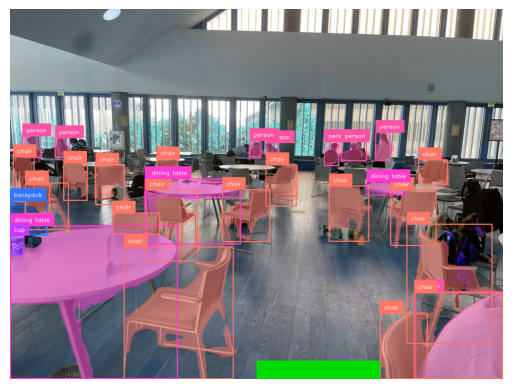

In [14]:
# Ensure you have: midas (model_depth), midas_transform, and YOLO seg model ready
img = cv2.imread(r"../images/image4.jpg")
import time 
# img = cv2.resize(img, (640, 640), interpolation=cv2.INTER_AREA)

t0=time.time()
A = clear_pixel_path(
    img, model, midas, midas_transform, device,
    group_width=64, focus_band=(0.6, 1.0),
    occ_max=0.02, near_threshold=0.6, near_max=0.2,
    return_scores=True
)
if len(A)==4:
    annotated_image,clear_groups, ranges, scores = A
elif len(A)==3:
    annotated_image,clear_groups, ranges = A
# print("Clear groups:", clear_groups)
# print("Ranges:", ranges)
# print(annotated_image.shape)
# img_640 = cv2.resize(img, (640, 640), interpolation=cv2.INTER_AREA)

viz = visualize_groups(annotated_image, clear_groups, group_width=64, focus_band=(0.6, 1.0))
t1=time.time()
print(f"Inference time: {t1-t0}")
# plt.imshow(cv2.cvtColor(viz, cv2.COLOR_BGR2RGB)); plt.axis("off"); plt.show()

plt.imshow(viz); plt.axis("off"); plt.show()

In [15]:
from ultralytics import YOLO
import supervision as sv
import torch
import cv2
import numpy as np
import traceback

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
video_path = "../videos/video0.mp4"
collect = []

try:
    # Use OpenCV VideoCapture instead of imageio
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
            
        # Frame is already in BGR format with OpenCV, no conversion needed!
        # if frame_count % 2 != 0:
        #     frame_count += 1
        #     continue
            
        # Process every 10th frame
        A = clear_pixel_path(
            frame, model, midas, midas_transform, device,
            group_width=64, focus_band=(0.6, 1.0),
            occ_max=0.02, near_threshold=0.6, near_max=0.2,
            return_scores=False
        )
        if len(A)>4:
            collect.append(A)
            continue
        elif len(A)==3:
            annotated_image, clear_groups, ranges =A
        elif len(A)==4:
            annotated_image, clear_groups, ranges, score=A
        viz = visualize_groups(annotated_image, clear_groups, group_width=64, focus_band=(0.6, 1.0))
        collect.append(viz)
        
        print(f"Processed frame {frame_count}")
        frame_count += 1
        
        # Optional: break early for testing
        # if frame_count > 100:  # Process only first 100 frames for testing
        #     break

    cap.release()
    print(f"Processed {frame_count} frames total")
    
except Exception:
    traceback.print_exc()

# Write output video
if collect:
    height, width, _ = collect[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('../videos/video0_obj_det-seg_depth_output.mp4', fourcc, 30.0, (width, height))

    for img in collect:
        out.write(img)
    out.release()

Processed frame 0
Processed frame 1
Processed frame 2
Processed frame 3
Processed frame 4
Processed frame 5
Processed frame 6
Processed frame 7
Processed frame 8
Processed frame 9
Processed frame 10
Processed frame 11
Processed frame 12
Processed frame 13
Processed frame 14
Processed frame 15
Processed frame 16
Processed frame 17
Processed frame 18
Processed frame 19
Processed frame 20
Processed frame 21
Processed frame 22
Processed frame 23
Processed frame 24
Processed frame 25
Processed frame 26
Processed frame 27
Processed frame 28
Processed frame 29
Processed frame 30
Processed frame 31
Processed frame 32
Processed frame 33
Processed frame 34
Processed frame 35
Processed frame 36
Processed frame 37
Processed frame 38
Processed frame 39
Processed frame 40
Processed frame 41
Processed frame 42
Processed frame 43
Processed frame 44
Processed frame 45
Processed frame 46
Processed frame 47
Processed frame 48
Processed frame 49
Processed frame 50
Processed frame 51
Processed frame 52
Pro

# Image Segmentation 

Depth timing -> original: 0.054s, resized(640): 0.038s
(960, 1280, 3)
(480, 640, 3)


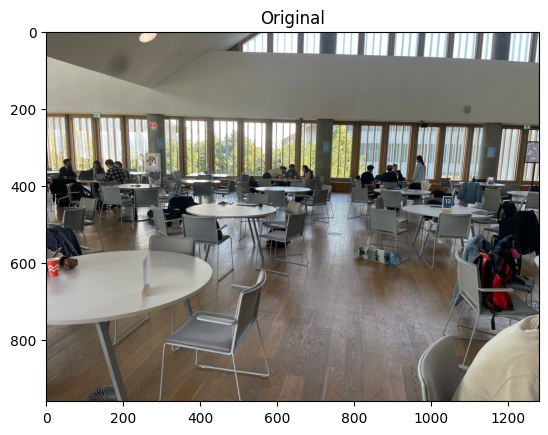

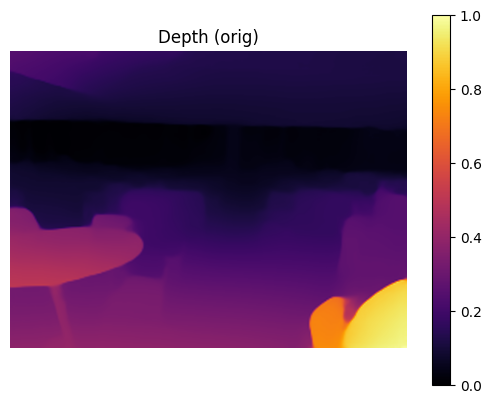

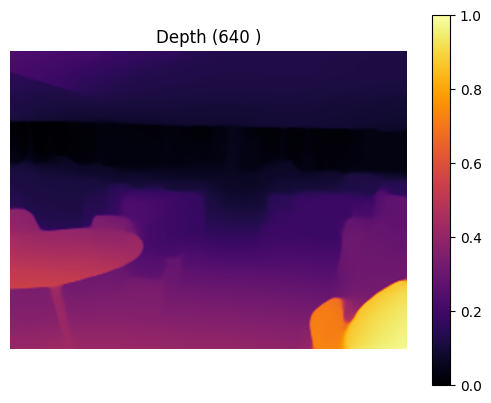

In [16]:

image_path = r"../images/image4.jpg"
img = cv2.imread(image_path)
img_resized = resize_and_pad(img, (640, 640))

t0 = time.time()
depth_vis_orig, depth_raw_orig = depth_estimation_image(midas, midas_transform, img, device)
t1 = time.time()
depth_vis_resz, depth_raw_resz = depth_estimation_image(midas, midas_transform, img_resized, device)
t2 = time.time()

print(f"Depth timing -> original: {t1 - t0:.3f}s, resized(640): {t2 - t1:.3f}s")

# plt.figure(figsize=(4,16))
print(depth_vis_orig.shape)
print(depth_vis_resz.shape)
plt.title("Original"); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.show()
plt.title("Depth (orig)"); a=plt.imshow(depth_vis_orig,cmap="inferno",vmin=0.0,vmax=1.0);plt.colorbar(a);plt.axis("off"); plt.show()
plt.title("Depth (640 )"); a=plt.imshow(depth_vis_resz,cmap="inferno",vmin=0.0,vmax=1.0);plt.colorbar(a);plt.axis("off"); plt.show()


In [ ]:
# # Install once:
# # !pip install ultralytics supervision opencv-python
# t0=time.time()
# image = cv2.imread(image_path)
# image_input = resize_and_pad(image)

# t1=time.time()
# image_output0 = segmentation_image(model,image)
# t2=time.time()
# image_output = segmentation_image(model,image_input)
# t3=time.time()
# print(f"Time analysis :Reading image + Resizing,t1-t0: {t1-t0},\nsegment original: t2-t1: {t2-t1}, \nSegment resized, t3-t2: {t3-t2}")
# plt.imshow(image)
# plt.show()
# plt.imshow(image_input)
# plt.show()
# plt.imshow(image_output)
# plt.show()
# import time

# model=YOLO(model_path)
# for fname in os.listdir(images_path):
#         if not fname.lower().endswith((".jpg","jpeg",".png")):
#             continue 
#         p = os.path.join(images_path, fname)
#         img = cv2.imread(p)
#         image = resize_and_pad(img)

# import time 
# t0=time.time()
# object_detection_images()
# t1 = time.time()
# print(t1-t0)
# video_path = "../videos/video0.mp4" # Your video path 
# collect = []
# try:
#     reader = imageio.get_reader(video_path, 'ffmpeg') # 'ffmpeg' is a common plugin
#     for i, frame in enumerate(reader):
#         # 'frame' is a NumPy array (RGB by default with imageio)
#         frame = resize_and_pad(frame)
#         pil_image = Image.fromarray(frame)
#         if (i%50==0):
#             # plt.imshow(pil_image)
#             # plt.show()
#             collect.append(collect1)

#         # Now you can use pil_image with Pillow functions
#         # pil_image.save(f"frame_{i:04d}.png")

#     reader.close()
#     print(f"Processed {i+1} frames.")
# except Exception as e:
#     print(f"Error: {e}")
# annotated_images = []
# for j in range(len(collect)):
#     results = model(collect[j])
#     for i,result in enumerate(results):
#         image = collect[j][i]
#         detections = sv.Detections.from_ultralytics(result)
#         # Annotate the image

#         annotated_image = sv.BoxAnnotator().annotate(
#             scene = image,
#             detections=detections
#         )

#         # Add label
#         annotated_image = sv.LabelAnnotator().annotate(
#             scene = annotated_image,
#             detections = detections
#         )
#         annotated_images.append(annotated_image)

# import cv2
# import numpy as np
# # Define the codec and create VideoWriter object
# height, width, _ = np.array(annotated_images[0]).shape
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# out = cv2.VideoWriter('../videos/output_object_detection.mp4', fourcc, 30.0, (width, height))

# for img in annotated_images:
#     img = np.array(img)
#     out.write(img)
# out.release()

# import os
# import cv2
# import numpy as np
# from ultralytics import YOLO
# import supervision as sv

# # Use the fastest segmentation model available locally
# CANDIDATE_MODELS = [
#     r"C:\Users\arofe\Aro_Data\IW_cv\model\yolov8n-seg.pt"
# ]
# MODEL_PATH = next((p for p in CANDIDATE_MODELS if os.path.exists(p)), "yolov8n-seg.pt")

# # Input image and outputs
# IMAGE_PATH = r"C:\Users\arofe\Aro_Data\IW_cv\images\image4.jpg"
# OUT_DIR = os.path.join(os.path.dirname(IMAGE_PATH), "segmented")
# os.makedirs(OUT_DIR, exist_ok=True)

# # Load model (set device="cuda" for GPU if available; fp16 for speed on supported GPUs)
# model = YOLO(MODEL_PATH)
# names = model.names

# # Read image
# img = cv2.imread(IMAGE_PATH)
# assert img is not None, f"Cannot read image: {IMAGE_PATH}"

# # Inference
# res = model(img, task="segment", conf=0.25, iou=0.45, verbose=False, device="cpu")[0]
# detections = sv.Detections.from_ultralytics(res)

# # Annotators
# palette = sv.ColorPalette.DEFAULT
# mask_annotator = sv.MaskAnnotator(color=palette, opacity=0.5)
# label_annotator = sv.LabelAnnotator(text_scale=0.6, text_thickness=1, color=palette)

# # Labels
# labels = [
#     f"{names.get(int(c), str(int(c)))} {conf:.2f}"
#     for c, conf in zip(detections.class_id , detections.confidence )
# ]

# # Draw segmentation masks + labels
# annotated = mask_annotator.annotate(scene=img.copy(), detections=detections)
# annotated = label_annotator.annotate(scene=annotated, detections=detections, labels=labels)

# # Save overlay
# overlay_path = os.path.join(OUT_DIR, "image4_segmented_overlay.jpg")
# cv2.imwrite(overlay_path, annotated)

# # # Optional: save cutouts for each instance
# # for i in range(len(detections)):
# #     # binary mask HxW
# #     m = detections.mask[i].astype(np.uint8) * 255
# #     # colored cutout on black background
# #     cutout = cv2.bitwise_and(img, img, mask=m)
# #     cls = names.get(int(detections.class_id[i]), str(int(detections.class_id[i])))
# #     cv2.imwrite(os.path.join(OUT_DIR, f"cutout_{i:02d}_{cls}.png"), cutout)
# #     cv2.imwrite(os.path.join(OUT_DIR, f"mask_{i:02d}_{cls}.png"), m)

# print(f"Saved overlay to: {overlay_path}")

Saved overlay to: C:\Users\arofe\Aro_Data\IW_cv\images\segmented\image4_segmented_overlay.jpg


Free space analysis completed:
- Total detections: 31
- Obstacle detections: 25
- Free space percentage: 82.2%


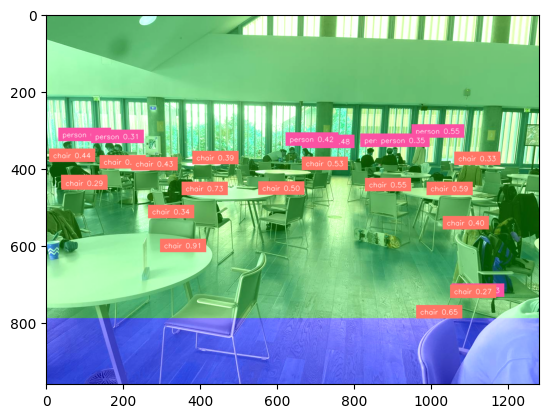

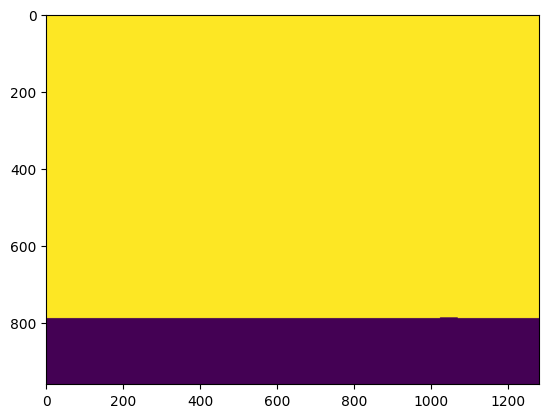


Free space mask saved as binary image (white=free, black=obstacle)


In [18]:
import os
import cv2
import numpy as np
from ultralytics import YOLO
import supervision as sv

# Use the fastest segmentation model available locally
CANDIDATE_MODELS = [
    r"../model/yolov8n-seg.pt"
]
MODEL_PATH = next((p for p in CANDIDATE_MODELS if os.path.exists(p)), "yolov8n-seg.pt")

# Input image and outputs
IMAGE_PATH = r"../images/image4.jpg"
OUT_DIR = os.path.join(os.path.dirname(IMAGE_PATH), "segmented")
os.makedirs(OUT_DIR, exist_ok=True)

# Load model
model = YOLO(MODEL_PATH)
names = model.names

# Read image
img = cv2.imread(IMAGE_PATH)
assert img is not None, f"Cannot read image: {IMAGE_PATH}"
height, width = img.shape[:2]

# Inference
res = model(img, task="segment", conf=0.25, iou=0.45, verbose=False, device="cpu")[0]
detections = sv.Detections.from_ultralytics(res)

# Define objects that represent obstacles (customize based on your needs)
OBSTACLE_CLASSES = ['person', 'car', 'truck', 'bus', 'motorcycle', 'bicycle', 
                   'bench', 'fence', 'wall', 'building', 'chair', 'table']

# Filter detections to only include obstacle classes
obstacle_indices = [
    i for i, class_id in enumerate(detections.class_id) 
    if names.get(int(class_id), str(int(class_id))) in OBSTACLE_CLASSES
]

obstacle_detections = detections[obstacle_indices]

def create_free_space_mask(detections, image_shape, use_nearest=True):
    """
    Create a free space mask by combining obstacle masks and optionally using the nearest obstacle as boundary
    """
    height, width = image_shape[:2]
    
    # Start with a completely free space (white mask)
    free_space_mask = np.ones((height, width), dtype=np.uint8) * 255
    
    if len(detections) == 0:
        return free_space_mask
    
    # Combine all obstacle masks
    obstacle_mask = np.zeros((height, width), dtype=np.uint8)
    
    for mask in detections.mask:
        # Convert mask to binary and add to obstacle mask
        if mask is not None:
            binary_mask = mask.astype(np.uint8) * 255
            obstacle_mask = cv2.bitwise_or(obstacle_mask, binary_mask)
    
    if use_nearest and len(detections) > 0:
        # Find the nearest obstacle based on bounding box center y-coordinate
        # (higher y-value means closer to bottom of image = nearer to camera)
        nearest_idx = None
        max_y_center = -1
        
        for i, bbox in enumerate(detections.xyxy):
            y_center = (bbox[1] + bbox[3]) / 2
            if y_center > max_y_center:
                max_y_center = y_center
                nearest_idx = i
        
        if nearest_idx is not None:
            # Use only the nearest obstacle to define free space boundary
            nearest_mask = detections.mask[nearest_idx].astype(np.uint8) * 255
            
            # Create a boundary above the nearest obstacle
            nearest_bbox = detections.xyxy[nearest_idx]
            boundary_y = int(nearest_bbox[1])  # Top of the nearest obstacle
            
            # Create a horizontal boundary mask
            boundary_mask = np.zeros((height, width), dtype=np.uint8)
            boundary_mask[0:boundary_y, :] = 255  # Free space above the boundary
            
            # Combine with nearest obstacle mask
            obstacle_mask = cv2.bitwise_or(nearest_mask, 255 - boundary_mask)
    
    # Remove obstacles from free space
    free_space_mask = cv2.bitwise_and(free_space_mask, 255 - obstacle_mask)
    
    return free_space_mask, obstacle_mask

# Create free space mask
free_space_mask, obstacle_mask = create_free_space_mask(obstacle_detections, img.shape)

# Create visualization
def visualize_free_space(image, free_space_mask, obstacle_mask, detections, names):
    """Create visualization of free space"""
    # Create base image
    vis_img = image.copy()
    
    # Create colored overlay for free space (green)
    free_space_overlay = np.zeros_like(vis_img)
    free_space_overlay[free_space_mask == 255] = [0, 255, 0]  # Green for free space
    
    # Create colored overlay for obstacles (red)
    obstacle_overlay = np.zeros_like(vis_img)
    obstacle_overlay[obstacle_mask == 255] = [0, 0, 255]  # Red for obstacles
    
    # Combine overlays with transparency
    alpha_free = 0.3
    alpha_obstacle = 0.5
    
    vis_img = cv2.addWeighted(vis_img, 1, free_space_overlay, alpha_free, 0)
    vis_img = cv2.addWeighted(vis_img, 1, obstacle_overlay, alpha_obstacle, 0)
    
    # Add labels for obstacles
    label_annotator = sv.LabelAnnotator(text_scale=0.6, text_thickness=1)
    labels = [
        f"{names.get(int(c), str(int(c)))} {conf:.2f}"
        for c, conf in zip(detections.class_id, detections.confidence)
    ]
    vis_img = label_annotator.annotate(scene=vis_img, detections=detections, labels=labels)
    
    return vis_img

# Create visualization
free_space_vis = visualize_free_space(img, free_space_mask, obstacle_mask, obstacle_detections, names)

# Save results
overlay_path = os.path.join(OUT_DIR, "image4_segmented_overlay.jpg")
free_space_path = os.path.join(OUT_DIR, "image4_free_space.jpg")
mask_path = os.path.join(OUT_DIR, "image4_free_space_mask.png")

# cv2.imwrite(overlay_path, annotated)
cv2.imwrite(free_space_path, free_space_vis)
cv2.imwrite(mask_path, free_space_mask)

print(f"Free space analysis completed:")
print(f"- Total detections: {len(detections)}")
print(f"- Obstacle detections: {len(obstacle_detections)}")
print(f"- Free space percentage: {np.sum(free_space_mask == 255) / (height * width) * 100:.1f}%")
plt.imshow(free_space_vis)

plt.show()
plt.imshow(free_space_mask)

plt.show()
# Display the free space mask properties
print(f"\nFree space mask saved as binary image (white=free, black=obstacle)")